In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pandas as pd
from matplotlib import pyplot as plt
import random

In [2]:
train_ds,validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]","train[40%:50%]","train[50%:60%]"],
    as_supervised=True     
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteLJ8RKF/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


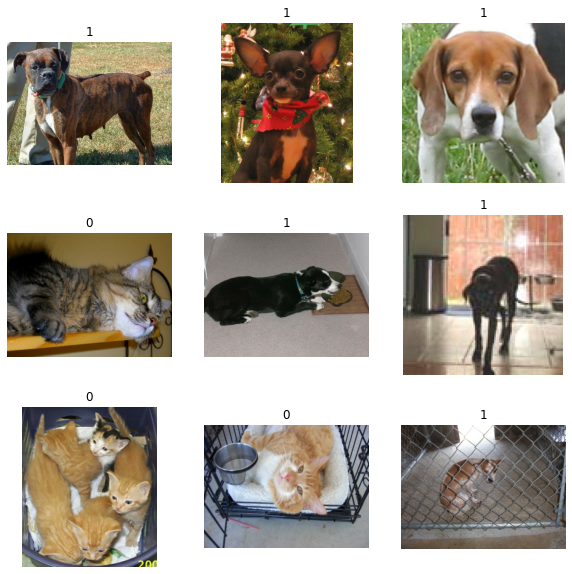

In [11]:
plt.figure(figsize=(10,10))
for i, (image,label) in enumerate (train_ds.take(9)):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In [4]:
size=(150,150)

train=train_ds.map(lambda x,y: (tf.image.resize(x,size),y))
validation=validation_ds.map(lambda x,y: (tf.image.resize(x,size),y))
test=test_ds.map(lambda x,y: (tf.image.resize(x,size),y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
batch_size=32
train = train.cache().batch(batch_size).prefetch(buffer_size=10)
validation = validation.cache().batch(batch_size).prefetch(buffer_size=10)
test = test.cache().batch(batch_size).prefetch(buffer_size=10)

In [7]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),layers.RandomRotation(0.1)]
)

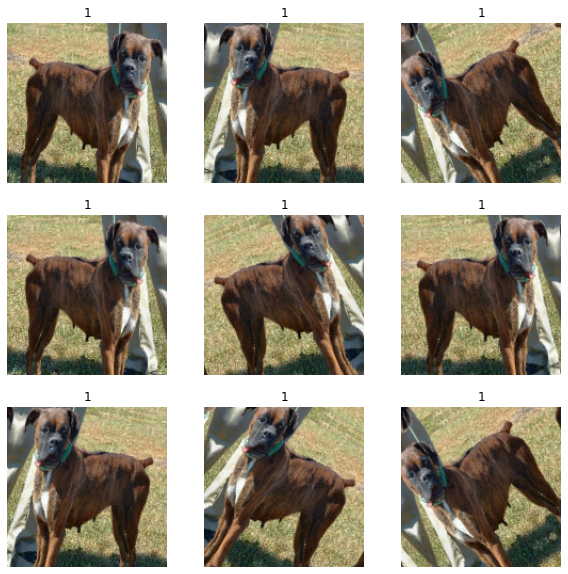

In [12]:
for images,labels in train.take(1):
  plt.figure(figsize=(10,10))
  first=images[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented=data_augmentation(
        tf.expand_dims(first,0), training=True
    )
    plt.imshow(augmented[0].numpy().astype("int32"))
    plt.title(int(label))
    plt.axis("off")


In [9]:
base_model=keras.applications.Xception(
    weights="imagenet",
    input_shape=(150,150,3),
    include_top=False,
)

base_model.trainable=False
inputs = keras.Input(shape=(150,150,3))
xx=data_augmentation(inputs)
scale_layer = keras.layers.Rescaling(scale=1/127.5,offset=-1)
xx=scale_layer(xx)
xx=base_model(xx, training=False)
xx=keras.layers.GlobalAveragePooling2D()(xx)
xx=keras.layers.Dropout(0.2)(xx)
outputs=keras.layers.Dense(1)(xx)
model=keras.Model(inputs,outputs)
model.summary()

83683744/83683744 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs=2

model.fit(train,epochs=epochs, validation_data=validation)

Epoch 1/2


291/291 [==============================] - 1160s 4s/step - loss: 0.1780 - binary_accuracy: 0.9200 - val_loss: 0.0841 - val_binary_accuracy: 0.9703
Epoch 2/2
291/291 [==============================] - 1121s 4s/step - loss: 0.1211 - binary_accuracy: 0.9488 - val_loss: 0.0754 - val_binary_accuracy: 0.9708


In [15]:
base_model.trainable=True
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs=1

model.fit(train,epochs=epochs, validation_data=validation)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

291/291 [==============================] - 3832s 13s/step - loss: 0.0844 - binary_accuracy: 0.9652 - val_loss: 0.0510 - val_binary_accuracy: 0.9794


**Задание 2** Автоэнкодеры

In [21]:
from __future__ import absolute_import
from __future__ import division
import keras
from keras.datasets import mnist
import numpy as np
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K


In [22]:
# Считываем данные из MNIST
(x_train, _), (x_test, _) = mnist.load_data()
# Нормируем данные и приводим массивы к виду (N,size1,size1,1)
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [19]:
#Добавим шум
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
#Ограничимся отрезком 0, 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [20]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Зададим два сверточных слоя и число нейронов в каждом слое:
layer_filters = [32, 64]

In [23]:
encoder_inputs = Input(shape=input_shape, name='encoder_input')
x = encoder_inputs
# Стек из сверточных слоев (strides - дискрет сдвига окна свертки
# в пикселях, padding - без заполнения нулями):
for filters in layer_filters:
  x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    strides=2,
    activation='relu',
    padding='same')(x)

In [24]:
# Запоминаем размерность выхода для построения модели декодера
shape = K.int_shape(x)
# Преобразуем многомерный массив в вектор
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# Итоговый код - одномерный вектор меньшей размерности (latent_dim)

In [26]:
# Итоговая модель энкодера:
encoder = Model(encoder_inputs , latent, name='encoder')
Model: "encoder"

In [27]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# Обратное преобразование к размеру "shape":
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# Выход должен быть трехмерным массивом:
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [28]:
# Вместо сверточных слоев "разверточные", цикл в обратном порядке:
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
    kernel_size=kernel_size,
    strides=2,
    activation='relu',
    padding='same')(x)
x = Conv2DTranspose(filters=1,
  kernel_size=kernel_size,
  padding='same')(x)

In [29]:
outputs = Activation('sigmoid', name='decoder_output')(x)
# Итоговая модель декодера:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [30]:
autoencoder = Model(encoder_inputs,
  decoder(encoder(encoder_inputs)),
  name='autoencoder')

In [31]:
autoencoder.compile(loss='mse', optimizer='adam')

In [32]:
# Запускаем модель на обучение, используя незашумленные данные как эталонные.
autoencoder.fit(x_train_noisy,
  x_train,
  validation_data=(x_test_noisy, x_test),
  epochs=1,
  batch_size=batch_size)

469/469 [==============================] - 108s 226ms/step - loss: 0.0659 - val_loss: 0.0379


1/1 [==============================] - 0s 23ms/step


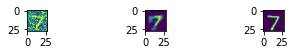

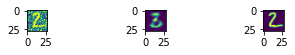

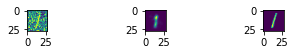

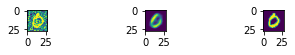

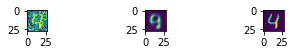

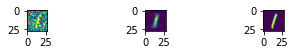

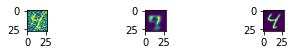

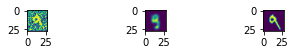

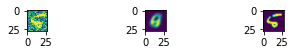

In [33]:
for i in range(9):
  plt.figure()
  plt.subplot(9 ,3, i*3 + 1)
  plt.imshow(x_test_noisy[i].reshape((28,28)))
  res = autoencoder.predict(x_test_noisy[i].reshape(1, 28, 28, 1)).reshape(28, 28)
  plt.subplot(9, 3, i*3 +2)
  plt.imshow(res)
  plt.subplot(9, 3, i*3 +3)
  plt.imshow(x_test[i].reshape((28,28)))